# Recommendations with IBM

This notebook was prepared as a part of data science sourse at [Udacity](https://www.udacity.com/). 

## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns 

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [3]:
print(df.shape)
print(df.nunique())

(45993, 3)
article_id     714
title          714
email         5148
dtype: int64


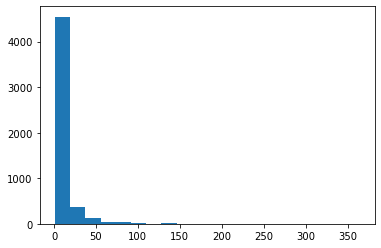

In [4]:
#groupby single column
plt.hist(df.groupby(['email'])['article_id'].count(), bins = 20)
plt.show()

In [5]:
print(df['email'].value_counts().describe())

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: email, dtype: float64


In [6]:
# Fill in the median and maximum number of user_article interactios below

median_val = df['email'].value_counts().median() 
print('50% of individuals interact with {} articles or fewer.'.format(median_val))
max_views_by_user = df['email'].value_counts().max()
print('The maximum number of user-article interactions by any 1 user is {}.'.format(max_views_by_user))

50% of individuals interact with 3.0 articles or fewer.
The maximum number of user-article interactions by any 1 user is 364.


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [7]:
# Find and explore duplicate articles
df_content.duplicated('article_id').value_counts()

False    1051
True        5
dtype: int64

In [8]:
df_content[df_content.duplicated('article_id', keep = False)]

,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [9]:
# Remove any rows that have the same article_id - only keep the first

df_content = df_content.drop_duplicates('article_id', keep = 'first')

#check
print(len(df_content[df_content.duplicated()]))


0


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [10]:
unique_articles = df['article_id'].nunique()
print('The number of unique articles that have at least one interaction: {}'.format(unique_articles))

total_articles = df_content['article_id'].nunique()
print('The number of unique articles on the IBM platform: {}'.format(total_articles))

unique_users = df['email'].nunique()
print('The number of unique users: {}'.format(unique_users))

user_article_interactions = len(df)
print('The number of user-article interactions: {}'.format(user_article_interactions))

The number of unique articles that have at least one interaction: 714
The number of unique articles on the IBM platform: 1051
The number of unique users: 5148
The number of user-article interactions: 45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  The `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [11]:
most_viewed_article_id = df['article_id'].mode().to_string(index = False)
print('The most viewed article in the dataset as a string with one value following the decimal: {}'.format(most_viewed_article_id)) 

max_views = df.groupby('article_id')['email'].count().max()
print('The most viewed article in the dataset was viewed how many times? {}'.format(max_views))

The most viewed article in the dataset as a string with one value following the decimal: 1429.0
The most viewed article in the dataset was viewed how many times? 937


In [12]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top.

In [13]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    df_ranked = df.groupby('title', as_index = False)['user_id'].count()
    df_ranked.columns = ['title', 'count']

    df_ranked =  df_ranked.sort_values(by = ['count'], ascending = False)

    top_articles = list(df_ranked['title'][:n])
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article ids
    
    '''

    df_ranked = df.groupby('article_id', as_index = False)['user_id'].count()
    df_ranked.columns = ['article_id', 'count']

    df_ranked =  df_ranked.sort_values(by = ['count'], ascending = False) 

    top_articles = list(df_ranked['article_id'][:n])
     
    return top_articles # Return the top article ids

In [14]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 


In [15]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Use only selected columns
    user_item = df[['user_id', 'article_id']]

    # Create matrix
    user_item = user_item.groupby(['user_id', 'article_id'])['article_id'].count().unstack()

    # Change count and Nan to 0-1
    for col in user_item.columns: 
        user_item[col] = user_item[col].apply(lambda x: 1 if x >= 1 else 0)
    
    # Remove MultiIndex
    #user_item = user_item.reset_index().rename_axis(None, axis=1)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [16]:
user_item.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

In [17]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    most_similar_users = user_item.loc[user_id, :] @ user_item.T # matmul used instead of np.dot

    # sort by similarity
    most_similar_users = most_similar_users.sort_values(ascending = False)

    # create list of just the ids
    most_similar_users = list(most_similar_users.index)
   
    # remove the own user's id
    most_similar_users.remove(user_id)
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [18]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [19]:
df.dtypes

article_id    float64
title          object
user_id         int64
dtype: object

In [20]:
df['article_id'] = df['article_id'].astype(str)

In [21]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
 
    article_names = list(df[df['article_id'].isin(article_ids)]['title'].unique())
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # select user
    user = user_item.loc[user_id]
    # articles seen by user - with 1
    article_ids = list(user.loc[user == 1].index)
    article_ids = list(map(str, article_ids)) # ids as str not as float    
    # associated names:
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # articles seen by user (article ids)
    articles_seen = get_user_articles(user_id)[0]
    # other users identified as similar (user ids)
    similar_users = find_similar_users(user_id)

    # recommendations stored here:
    recs = []

    # identify articles from similar users that the user hasn't seen
    for user in similar_users:
        similar_users_seen = get_user_articles(user)[0]

        # difference between sets to find new articles
        #new_recs = np.setdiff1d(set(similar_users_seen), set(articles_seen), assume_unique=True)
        recs = [x for x in set(similar_users_seen) if x not in set(articles_seen)]

        # stop when there are enough of new articles
        if len(recs) > m - 1:
            break

    recs = recs[:m]
    # recommendations as str not as float
    recs = list(map(str, recs))
    
    return recs # return your recommendations for this user_id    

In [22]:
user_user_recs(1)

['108.0',
 '1160.0',
 '729.0',
 '1171.0',
 '1432.0',
 '682.0',
 '943.0',
 '693.0',
 '74.0',
 '1181.0']

In [23]:
# Check Results
# Return 10 recommendations for user 1
get_article_names(user_user_recs(1, 10))

['visualize data with the matplotlib library',
 'discover hidden facebook usage insights',
 'analyze accident reports on amazon emr spark',
 'better together: spss and data science experience',
 '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
 'apache spark lab, part 2: querying data',
 'car performance data',
 'easy json loading and social sharing in dsx notebooks',
 'the 3 kinds of context: machine learning and the art of the frame',
 'pixiedust 1.0 is here! – ibm watson data lab']

`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [24]:
# convert index from float to intiger / string
user_item.index = user_item.index.map(int)

In [25]:
#check
#user_item.index[user_item.index != 1]
#user_item.loc[1] @ user_item.loc[10]
#df.groupby('user_id')['article_id'].count()

In [26]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # all remaining user ids
    neighbor_id = user_item.index[user_item.index != user_id]
    interactions = df.groupby('user_id')['article_id'].count()

    neighbors_df = []

    for neighbor in neighbor_id:
        similarity = user_item.loc[user_id] @ user_item.loc[neighbor]
        num_interactions = interactions[neighbor]
        neighbors_df.append({'neighbor_id': neighbor, 
                       'similarity': similarity, 'num_interactions': num_interactions})
    
    neighbors_df = pd.DataFrame(neighbors_df, columns = ['neighbor_id', 'similarity', 'num_interactions'])   

    neighbors_df = neighbors_df.sort_values(by = ['similarity', 'num_interactions'], ascending = False).reset_index(drop = True)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    
    # articles sorted by number of views
    articles_sorted = get_top_article_ids(len(df))
    # articles seen by user (article ids)
    articles_seen = get_user_articles(user_id)[0]
    
    # neighbors sorted by similarity and number of views (user ids)
    neighbors_df = get_top_sorted_users(user_id)
    neighbors = list(neighbors_df['neighbor_id'])

    # recommendations stored here:
    recs = []

    # identify articles from similar users that the user hasn't seen
    for user in neighbors:
        similar_users_seen = get_user_articles(user)[0]

        # articles seen by a similar user sorted by number of views
        similar_user_seen_sorted = [a for a in articles_sorted if a in similar_users_seen]

        # difference between users to find new articles
        recs = [x for x in set(similar_user_seen_sorted) if x not in set(articles_seen)]

        # stop when there are enough of new articles
        if len(recs) > m - 1:
            break

    recs = recs[:m]

    # article ids
    recs = list(map(str, recs))

    # article names
    rec_names = get_article_names(recs)    
    
    return recs, rec_names

In [27]:
get_top_sorted_users(1).head(5)

,neighbor_id,similarity,num_interactions
0,3933,35,45
1,23,17,364
2,3782,17,363
3,203,15,160
4,4459,15,158


In [28]:
user_user_recs_part2(20, 10)

(['1160.0',
  '1411.0',
  '12.0',
  '1354.0',
  '1420.0',
  '1170.0',
  '1157.0',
  '302.0',
  '1331.0',
  '1368.0'],
 ['apache spark lab, part 1: basic concepts',
  'timeseries data analysis of iot events by using jupyter notebook',
  'putting a human face on machine learning',
  'use apache systemml and spark for machine learning',
  'airbnb data for analytics: washington d.c. listings',
  'uci: white wine quality',
  'analyze accident reports on amazon emr spark',
  'accelerate your workflow with dsx',
  'intentional homicide, number and rate per 100,000 population, by country',
  'movie recommender system with spark machine learning'])

In [29]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1160.0', '1411.0', '12.0', '1354.0', '1420.0', '1170.0', '1157.0', '302.0', '1331.0', '1368.0']

The top 10 recommendations for user 20 are the following article names:
['apache spark lab, part 1: basic concepts', 'timeseries data analysis of iot events by using jupyter notebook', 'putting a human face on machine learning', 'use apache systemml and spark for machine learning', 'airbnb data for analytics: washington d.c. listings', 'uci: white wine quality', 'analyze accident reports on amazon emr spark', 'accelerate your workflow with dsx', 'intentional homicide, number and rate per 100,000 population, by country', 'movie recommender system with spark machine learning']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.

In [30]:
user1_most_sim = get_top_sorted_users(1)['neighbor_id'].iloc[0] # Find the user that is most similar to user 1 
print('The user that is most similar to user 1 is: {}'.format(user1_most_sim))

user131_10th_sim = get_top_sorted_users(131)['neighbor_id'].iloc[9] # Find the 10th most similar user to user 131
print('The 10th most similar user to user 131 is: {}'.format(user131_10th_sim))

The user that is most similar to user 1 is: 3933
The 10th most similar user to user 131 is: 242


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?

**If we were given a new user collaborative filtering might not work as expected since we don't have enough information on user-user or user-item interactions. In this case rank-based recommendations can be used to suggest top most popular/ most often seen/ most liked items to a new user.**

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.

In [32]:
new_user = '0.0'
# user_id for a new user does not influence top recommendations

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)

print('Top 10 articles recommended to a new user {} are: {}'.format(new_user, new_user_recs))

Top 10 articles recommended to a new user 0.0 are: ['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


### <a class="anchor" id="Matrix-Fact">Part IV: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.

In [35]:
# Load the matrix here
#user_item_matrix = pd.read_pickle('user_item_matrix.p')
user_item_matrix = user_item

In [36]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD.

In [38]:
# user with the highest average
print(user_item_matrix.mean(axis=1))

# article with highest average
print(user_item_matrix.mean(axis=0))

user_item_matrix.shape

user_id
1       0.050420
2       0.008403
3       0.056022
4       0.036415
5       0.004202
          ...   
5145    0.007003
5146    0.009804
5147    0.001401
5148    0.001401
5149    0.001401
Length: 5149, dtype: float64
article_id
0.0       0.002331
2.0       0.008545
4.0       0.002525
8.0       0.015925
9.0       0.001942
            ...   
1440.0    0.001554
1441.0    0.001165
1442.0    0.000777
1443.0    0.002331
1444.0    0.000971
Length: 714, dtype: float64


(5149, 714)

In [39]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)

u.shape, s.shape, vt.shape

((5149, 5149), (714,), (714, 714))

**SVD could be easily performed here because there are no missing values in the dataset. User-item matrix does not store rating but a variable 0-1 depending if a user has seen an item or not, so Nan values will not be a problem.**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

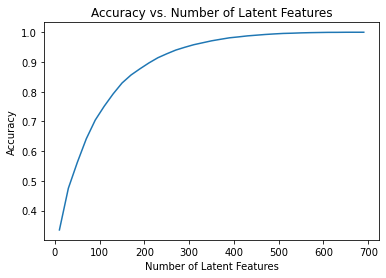

In [40]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [41]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''

    # create user-item matrix for train and test
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)

    # create series with user ids and article ids from test df
    test_idx = np.array(user_item_test.index)
    test_arts = np.array(user_item_test.columns)

    # fix different data points sequence for the common users
    # for further modelling the sequence of common items should be the same
    user_item_test = user_item_test[user_item_test.index.isin(list(user_item_train.index))]

    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [42]:
print(user_item_test[user_item_test == 1].sum().sum())

218.0


In [43]:
# users that are both in train and test set
no_old_users = len([x for x in test_idx if x in np.array(user_item_train.index)])
no_old_users

20

In [44]:
# users that are in the test set but not in train set - these are new users
no_new_users = len(test_idx) - no_old_users
no_new_users

662

In [45]:
# articles that are both in train and test set
no_old_articles = len([x for x in test_arts if x in np.array(user_item_train.columns)])
no_old_articles

574

In [46]:
# articles that are in test set but not in train set - new articles
no_new_articles = len(test_arts) - no_old_articles
no_new_articles

0

In [47]:
print('We can make predictions for {} users in the test set.'.format(no_old_users))
print('We are not able to make predictions for {} users in the test set because of the cold start problem.'.format(no_new_users))
print('We can make predictions for {} articles in the test set.'.format(no_old_articles))
print('We are not able to make predictions for {} articles in the test set because of the cold start problem.'.format(no_new_articles))

We can make predictions for 20 users in the test set.
We are not able to make predictions for 662 users in the test set because of the cold start problem.
We can make predictions for 574 articles in the test set.
We are not able to make predictions for 0 articles in the test set because of the cold start problem.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [48]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)
u_train.shape, s_train.shape, vt_train.shape

# fit svd similar to above then use the cells below

((4487, 4487), (714,), (714, 714))

In [49]:
# subset of rows in the user_item_test dataset that we can predict
old_users = [x for x in test_idx if x in np.array(user_item_train.index)]

subset_user_item_test = user_item_test[user_item_test.index.isin(old_users)]

subset_user_item_test.shape

(20, 574)

In [50]:
#u matrix should be limited to users we can make predictions for 

u_test = u_train[user_item_train.index.isin(old_users), :]
u_test.shape

(20, 4487)

In [51]:
#v matrix should be limited to test dataset
vt_test = vt_train[:, user_item_train.columns.isin(test_arts)]
vt_test.shape

(714, 574)

In [52]:
num_latent_feats = np.arange(5, 500+10, 10)
sum_errs_train = []
sum_errs_test = []

for k in num_latent_feats:
    # restructure train df with k latent features
    s_new_train, u_new_train, vt_new_train = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]

    # restructure train df with k latent features - test
    u_new_test, vt_new_test = u_test[:, :k], vt_test[:k, :]
    
    # take dot product - train
    user_item_est_train = np.around(np.dot(np.dot(u_new_train, s_new_train), vt_new_train))

    # take dot product - test
    user_item_est_test = np.around(np.dot(np.dot(u_new_test, s_new_train), vt_new_test))
    
    # compute error for each prediction to actual value - train
    diffs_train = np.subtract(user_item_train, user_item_est_train)

    # compute error for each prediction to actual value - test
    diffs_test = np.subtract(subset_user_item_test, user_item_est_test)
    
    # total errors and keep track of them - train
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    sum_errs_train.append(err_train)

    # total errors and keep track of them - test
    err_test = np.sum(np.sum(np.abs(diffs_test)))
    sum_errs_test.append(err_test)   


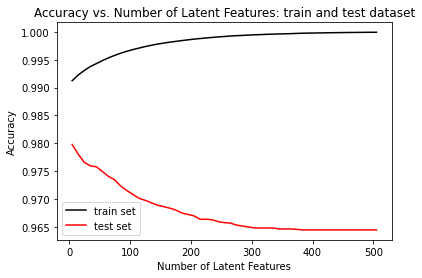

In [53]:
plt.plot(num_latent_feats, 1 - np.array(sum_errs_train)/(user_item_train.shape[0]*user_item_train.shape[1]), 
            label = 'train set', color = 'black');
plt.plot(num_latent_feats, 1 - np.array(sum_errs_test)/(user_item_test.shape[0]*user_item_test.shape[1]), 
            label = 'test set', color = 'red');

plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features: train and test dataset');
plt.legend();
plt.show()

We notice that the accuracy grows as latent features are added up to the point when adding an additional feature doesn't change accuracy. Increasing number of latent features rapidly decreases accuracy of the model on test dataset. This might be a sign of overfitting, since the model works well on training set, but is not able to generalize on unseen data.** 

There are only 20 users in the test dataset, this might not be sufficient and we cannot exacly say how well the recommendation is working and it might be the case that there are too many features for such a small dataset. Accuracy might not be the best metric to evaluate model performance with such a small test data and binary variables.

**Cold start problem is common when intorducing recommendation system to new users and might make it difficult to decide if the model could be successfuly productionize. We could consider running A/B testing on the website to get more insight on how recommendation system is working. Group A would see an old version of the site with the deafult article listing and gorup B would see a list of articles as recommended by the model. We could split the users using cookie-based diversion (number of cookies at homepage as our invariant matrix) and ratio: number of clicks vs number of cookies as our evaluation metric. Looking at historical entries we could calculate for how long the experiment should run to make the results statistically significant. This could help us decide if our recommendation system is meaningful or needs further improving on larger test dataset.